In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from sklearn.model_selection import train_test_split

from collections import Counter
from models import model__prior_mu_studentT as model 

### Data Processing

In [2]:
scaler = StandardScaler()
df = pd.read_pickle('../pickle/df.pkl')

In [3]:
df_sampled = df.sample(1400,random_state=47)

In [4]:
df_features = df_sampled.iloc[:,:-1].copy()
df_target = df_sampled.iloc[:,-1].copy()

In [5]:
df_features = scaler.fit_transform(df_features)

In [6]:
df_train_features, df_test_features,df_train_target, df_test_target =  train_test_split(df_features,df_target,stratify=df_target,random_state=47, test_size=1/7)

df_train_features, df_val_features,df_train_target, df_val_target =  train_test_split(df_train_features,df_train_target,stratify=df_train_target,random_state=47, test_size=1/6)

In [7]:
df_train_target = df_train_target.to_numpy()
df_test_target = df_test_target.to_numpy()
df_val_target = df_val_target.to_numpy()

In [8]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
N_val = df_val_features.shape[0]
n_cat = 11 
degF=4
tau=1

### Ancestral Sampling 

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [ 0.24257503  1.15498608  1.22494402  2.38651367  0.13095129  1.19010084
  0.57810289 -1.59840604  0.59455028  1.97147916 -0.79880541 -1.84156307
 -0.00708448  0.47833973]


In [11]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))

In [12]:
counts = Counter(label_array)

In [13]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.085


In [14]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Final Model training 

In [15]:
degF=4
tau=1

In [16]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 15000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 5069.0
[1000] ELBO: 2249.5
[2000] ELBO: 1857.9
[3000] ELBO: 1741.2
[4000] ELBO: 1680.7
[5000] ELBO: 1655.7
[6000] ELBO: 1636.8
[7000] ELBO: 1639.7
[8000] ELBO: 1636.4
[9000] ELBO: 1634.3
[10000] ELBO: 1632.8
[11000] ELBO: 1624.7
[12000] ELBO: 1631.0
[13000] ELBO: 1632.1
[14000] ELBO: 1638.4


In [17]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

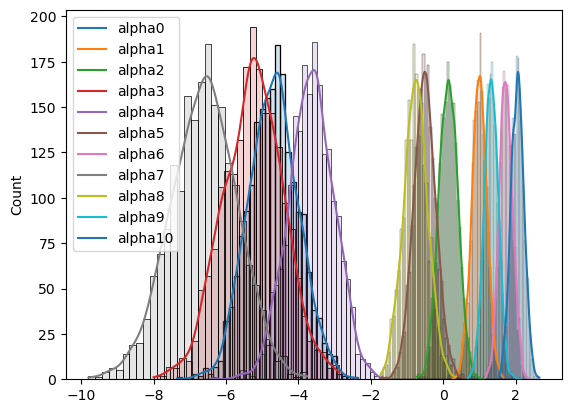

In [18]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

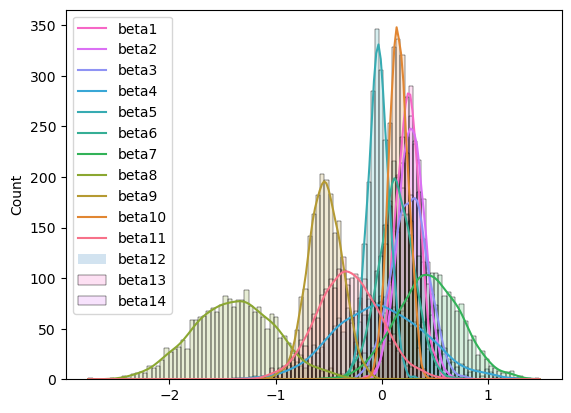

In [19]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [20]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

C:\Users\MNIS\AppData\Local\Temp\ipykernel_12528\2012132113.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)
  mean_alpha = mean_alpha.T


### Inference and computation of accuracy on the train dataset 

In [21]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [22]:
y_train_pred = y_train_pred[:,0]

In [23]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.505


### Inference and computation of accuracy on the test dataset 

In [24]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [25]:
y_test_pred = y_test_pred[:,0]

In [26]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.465
